In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST

In [ ]:
print(torch.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#import os
#os.chdir("/content/drive/My Drive") 
import ra
#import complexLayers


In [3]:
dataset = ra.read('atomsroa.ra')
train_data = torch.tensor(dataset)

In [4]:
train_data = train_data.imag
train_data =  torch.transpose(train_data, 0, 1).unsqueeze(1)

In [5]:
labelset = ra.read('paramsroa.ra')
train_label1 = torch.tensor(labelset)

In [6]:
dataset1 = ra.read('atoms.ra')
traindata1 = torch.tensor(dataset1)
traindata1 = traindata1.imag
traindata1 =  torch.transpose(traindata1, 0, 1).unsqueeze(1)
label1 = ra.read('params.ra')
label1 = torch.tensor(label1)

In [ ]:
print(traindata1)
print(train_data)

In [7]:
print(traindata1.shape)
train_data.shape

torch.Size([108056, 1, 1000])


torch.Size([108056, 1, 1000])

In [8]:
alldata = torch.cat((train_data,traindata1),0)

In [9]:
labels1 = torch.cat((train_label1[:-1,:],label1[:-1,:]),1)

In [ ]:
print(labels1)
print(labels1.shape)
print(train_label1.shape)

In [10]:
labels1 = torch.transpose(labels1, 0, 1)
print(labels1.shape)

torch.Size([216112, 2])


In [11]:
import torch.utils.data as data
train_dataset = data.TensorDataset(alldata,labels1)

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=10).fit_transform(train_data)

In [ ]:
pca = PCA(n_components=10)
pca.fit(train_data)

print(pca.explained_variance_ratio_.shape)
print(pca.components_.shape)
print(pca.singular_values_.shape)
print(pca.mean_.shape)

In [ ]:
train_data = torch.tensor(X_reduced)

In [12]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [140000, 60000 ,16112])

We found that the network model with smallest
average error for validation data consists of 3 convolutional layers (kernel size = 3, stride
size = 2), each followed by a rectified linear unit (ReLU) activation function. The number
of the feature maps per convolutional layer is increasing, from 32 in the first to 128 in
the last. After convolution an average pooling layer follows with the same size as the
stride size. The last layer is fully connected, with 2 outputs. 

In [30]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(36, 18),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(18, 9),
            nn.ReLU(inplace=True),
            nn.Linear(9, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [31]:
N = 500
val_loss = list()
#val_accu = list()
train_loss = list()
#train_accu = list()

In [32]:
#assert torch.cuda.is_available()
device1 = "cuda:0" if torch.cuda.is_available() else "cpu"
#cuda_device = torch.device("cuda")
seed = 7
torch.manual_seed(seed)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

def loss_batch(model, loss_func, xb, yb, opt=None):
    outputs = model(xb.float())
    yb = yb.float()
    outputs = torch.squeeze(outputs, 1)
    loss = loss_func(outputs, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
!pip install pycuda
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name() # '0' is the id of your GPU

In [33]:

# build the model
model = AlexNet().to(device1)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

# the epoch loop
for epoch in range(N):
    model.train()
    running_loss = 0.0
    loss=0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        #inputs = inputs.unsqueeze(1).unsqueeze(-1)
        #inputs = inputs.unsqueeze(1)
        #inputs = torch.unsqueeze(inputs1, 2)

        inputs, labels = inputs.to(device1), labels.to(device1)
        
        
        loss, nums = loss_batch(model, loss_function, inputs.float(), labels.float(), optimiser)
        running_loss += loss
    train_loss.append(loss)

    model.eval()
    with torch.no_grad():
        losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in validloader]
            )
        val_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_loss.append(val_loss1)


        #print(epoch, val_loss)

        
        # keep track of the loss this epoch
        #running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
print('**** Finished Training ****')

Epoch 0, loss 1065646661.94
Epoch 1, loss 664284255.62
Epoch 2, loss 477259261.94
Epoch 3, loss 374547090.64
Epoch 4, loss 347174153.20
Epoch 5, loss 318614639.98
Epoch 6, loss 294702083.98
Epoch 7, loss 267791674.80
Epoch 8, loss 247684958.22
Epoch 9, loss 237548341.73
Epoch 10, loss 230973168.02
Epoch 11, loss 221748706.17
Epoch 12, loss 212548581.34
Epoch 13, loss 209417011.80
Epoch 14, loss 205041235.39
Epoch 15, loss 201026626.94
Epoch 16, loss 201328565.83
Epoch 17, loss 199383086.53
Epoch 18, loss 199938153.08
Epoch 19, loss 197118462.22
Epoch 20, loss 196667345.28
Epoch 21, loss 195583558.76
Epoch 22, loss 194414315.01
Epoch 23, loss 193389204.50
Epoch 24, loss 192152099.48
Epoch 25, loss 192340274.30
Epoch 26, loss 191710320.65
Epoch 27, loss 189982212.23
Epoch 28, loss 189244467.17
Epoch 29, loss 189143716.99
Epoch 30, loss 188419042.88
Epoch 31, loss 187532488.53
Epoch 32, loss 186745488.27
Epoch 33, loss 187700350.48
Epoch 34, loss 185673720.54
Epoch 35, loss 184349459.99
E

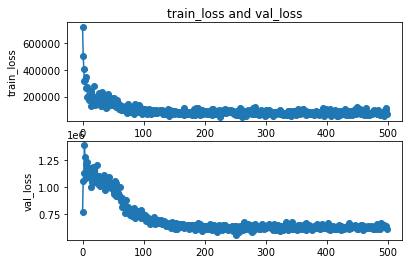

In [38]:
import matplotlib.pyplot as plt

x = range(0, N)
y1 = train_loss
#y2 = train_accu
y3 = val_loss
#y4 = val_accu
plt.subplot(2, 1, 1)
plt.plot(x, y1, 'o-')
plt.title('train_loss and val_loss')
plt.ylabel('train_loss')
#plt.subplot(2, 1, 2)
#plt.plot(x, y2, '.-')
#plt.xlabel('epoches')
#plt.ylabel('train_accu')
plt.subplot(2, 1, 2)
plt.plot(x, y3, 'o-')
plt.ylabel('val_loss')
#plt.subplot(2, 2, 2)
#plt.plot(x, y4, '.-')
#plt.title('val_loss and val_accu')
#lt.ylabel('val_accu')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [36]:
print(y1)

[723610.125, 506761.25, 406014.75, 318442.0625, 324482.4375, 349742.46875, 265207.09375, 274264.40625, 197610.796875, 196157.046875, 205276.109375, 177824.546875, 195399.546875, 244967.671875, 131594.375, 209869.46875, 193616.09375, 159896.1875, 278489.5, 156428.859375, 136150.046875, 146634.296875, 145561.53125, 159998.609375, 177155.734375, 196911.546875, 185860.75, 225835.671875, 190411.03125, 170642.640625, 134340.9375, 126430.046875, 233626.09375, 188790.6875, 135986.5, 195039.359375, 211411.59375, 188100.21875, 115885.109375, 175407.734375, 125499.859375, 146409.359375, 218017.921875, 148006.703125, 135066.359375, 177911.375, 137977.25, 186216.21875, 133693.625, 167962.109375, 134767.609375, 178239.484375, 189816.796875, 164265.875, 126301.515625, 118488.875, 133832.296875, 170772.359375, 127858.0, 143548.21875, 104503.359375, 127383.6796875, 123831.0234375, 96706.515625, 132594.203125, 111695.4609375, 104387.296875, 101745.125, 125332.3125, 117748.46875, 109018.953125, 129530.96

In [37]:
print(y3)

[767377.8520333334, 1053245.892, 1127493.5841333333, 1385919.232, 1274779.4134666666, 1086465.7572666667, 1211430.6888666668, 1129528.7248, 1227401.3829333333, 1088522.608, 1133738.8304666667, 1171826.5188, 1133231.9443333333, 1176747.4589333334, 1001822.6771333333, 1049541.5988333332, 1116729.7202666667, 1184643.2526666666, 1125615.4738666667, 1050720.5169666666, 1042468.4724, 1063566.25, 1095257.8264, 1082777.7672, 1200382.8949333334, 1031008.6517333334, 1065194.0761333334, 1100461.3625333332, 1094569.5508666667, 1011706.476, 1049319.6782, 1077534.7048, 1037050.0388666666, 1090643.2072, 1057930.7505333333, 1107843.7472666667, 1079878.2756, 967356.9656333333, 1020039.2730666667, 1031253.4299, 1039318.5011333333, 1043174.0392, 1028153.6421333334, 1095513.5569333334, 1005668.3911333333, 1049308.9224333332, 993212.4019, 1035906.8000333334, 995944.5939333333, 992191.1357333333, 1016790.2684, 931951.6832666667, 956368.9095333334, 1056547.5133333334, 914640.0119, 1032623.262, 912310.7377666

In [ ]:
model.eval()

In [ ]:
model.eval()
test_loss = list()
for data in testloader:
    losses, nums = zip(
                *[loss_batch(model.to(device1), loss_function, xb.to(device1), yb.to(device1)) for xb, yb in testloader])
    test_loss1 = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    test_loss.append(test_loss1)

In [ ]:
x = range(0, 126)
y3 = test_loss
plt.plot(x, y3, 'o-')
plt.title('test_loss')
plt.ylabel('test_loss')

In [ ]:
for data in testloader:
    inputs, lablels = data
    predictions = model(inputs.float())
    loss = loss_function(predictions,labels)
    loss = loss/128
    print("loss",loss)
    print("predicted parameter:", predictions)
    print("setting parameter:", labels)

In [ ]:
testdataset = ra.read('atomsroa.ra')
testdata = torch.tensor(testdataset)
testdata = testdata.imag
label1 = ra.read('paramsroa.ra')
label1 = torch.tensor(label1)

In [ ]:
for i in range(8056):
    inputs = testdata[:,i]
    lablels = label1[0,i]
    predictions = model(inputs.float())

    print("predicted parameter:", predictions)
    print("setting parameter:", lablels)

## Saving models

Being able to train a model is fine, but in practice once we've trained the model we probably want to save the result so we can reuse it at a later time. PyTorch makes saving the model easy using the torch.save(state, filepath) function. This will save the weights of the model so they can be loaded into a new instance at a later point.

Run the following code to save the weights for use in the next part of the lab.

In [ ]:
#save the trained model weights
torch.save(model.state_dict(), "./BaselineModel.weights")

If you are running on Colab, run the following to download the weights to the local machine:

In [ ]:
from google.colab import files
files.download('BaselineModel.weights')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BaselineModel(1000, 512, 256).to(device)
model.load_state_dict(torch.load('BaselineModel.weights'))